# Importing Libraries & Setting Ourselves Up to Succeed

The key things here are the requests for getting the data and the various bokeh imports to facilitate our first graphs together

In [5]:
import pandas as pd
from dateutil import parser
import requests 
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.embed import components
#from bokeh.layouts import column
import os
import math

os.chdir(r'C:\Users\AdamBarrett\bokeh-flask\data')
#sensor_dict ={'00011':'Temperature  Fahrenheit','00060':'Discharge Cubic-per-Second','00065':'Gage Height feet','00010':'Temperature Celsius'}
#location_dict = {'01129200':'Below Indian Stream NH','01129500':' North Stratford NH','01131500':'Near Dalton','01138500':'Wells River','01144500':'West Lebanon','01154500':'North Walpole','01161280':'Near Northfield','01172010':'I-391 Bridge @Holyoke','01184000':'Thompsonville','01190070':'Hartford CT','01193050':'Middle Haddam CT','01194750':'Essex CT','01194796':'Old Lyme CT'}

sensor_dict ={'63680':'Turbidity' ,'00095':'Conductivity', '00060':'Discharge Cubic-per-Second','00065':'Gage Height feet','00010':'Temperature Celsius'}
location_dict ={'02336000': 'Chatahooche River Atlanta', '02335000': 'Chatahooche River Near Norcross'}

def pull_usgs(sites, sensors, days, location, sensor_dict):
    """This is a function which takes a site number and a list of 
    sensors and number of days
    then creates and returns dataframe with a datetime index,
    names, ids and value"""  
     #set the formal constuctors of the final URL
    api_base = 'http://waterservices.usgs.gov/nwis/iv/?'
    form_state = 'format=json'
    site_slug ="&sites="
    params_slug = '&parameterCd='
    #both fixed and variable parameters to br gleened from HTML
#     params = '00060,00065' #(comma separated 00060,00065 allow selection)
#     sites ='01129500'#(get from web ) 
    period = '&period=P' +str(days) +'D'

    # the composite 
    url =api_base+form_state+site_slug+sites+period+params_slug+sensors

    #Accessing API data
    response = requests.get(url)
    
    #extracting the JSON from the response object
    raw = response.json()
    
    #Extracting the Data from the metadata JSON 
    data = raw['value']['timeSeries']
    stream_data =pd.DataFrame(columns=['date_time','site_id', 'site_name', 'sensor', 'sensor_code', 'value'])
    # The best Free JSON Tool ever made: http://chris.photobooks.com/json/default.htm
    
    #simple but ugly means of re-structuring heavily nested (GOVERNMENT) data
    for i, d in enumerate(data):
        #print('i {}: d: {}'.format(i,d))
        site_id = data[i]['name'].split(':')[1]
        site_n = location_dict[site_id]
        idn = data[i]['name'].split(':')[2]
        idw = sensor_dict[idn]
        #print(idn, idw, site_id)
        sub_data = data[i]['values'][0]['value']
        for j, d2 in enumerate(sub_data):
            value = sub_data[j]['value']
            date = parser.parse(sub_data[j]['dateTime']).strftime('%Y-%m-%d %H:%M')
            #print(dates, values)
            reading ={'date_time':date,
                         'site_id': site_id,
                         'site_name' : site_n,
                         'sensor':idw,
                         'sensor_code':idn,
                         'value':value}
            reading = pd.DataFrame.from_dict(reading, orient='index').T
            stream_data = stream_data.append(reading, ignore_index = True)
            
    #converting our dates and values to dates and values
    stream_data['date_time'] = pd.to_datetime(stream_data['date_time'])
    stream_data['value']=stream_data['value'].map(lambda x: float(x))
    
    # making a dataframe, grouping by sensor and date setting the index
    stream_data = pd.DataFrame(stream_data.groupby(['date_time', 'sensor_code'])['value'].mean())
    stream_data.reset_index(inplace=True)
    
    #Making the data wide future ease and human interpretability
    stream_data = stream_data.pivot(index='date_time',columns='sensor_code',values='value')
    return(sites, stream_data)


In [6]:
site, usgs = pull_usgs('02336000','00010,00060,00065,00095,63680', 3, location_dict, sensor_dict)

In [7]:
site

'02336000'

In [8]:
usgs.head()

sensor_code,00010,00060,00065,00095,63680
date_time,,,,,
2019-04-28 16:00:00,13.3,7890.0,7.68,55.0,10.8
2019-04-28 16:15:00,13.4,7850.0,7.65,55.0,10.4
2019-04-28 16:30:00,13.4,7800.0,7.62,55.0,9.7
2019-04-28 16:45:00,13.5,7770.0,7.60,55.0,9.7
2019-04-28 17:00:00,13.6,7740.0,7.58,55.0,10.0


## What would `matplotlib` do?

In [9]:
def stream_plotter(data, sensor_code, site , color = 'purple'):
    """Accepts a Dataframe, plotting color and column name
    returns a bokeh plot labeled with hovers"""
    sensor_dict ={'63680':'Turbidity' ,'00095':'Conductivity', '00060':'Discharge Cubic-per-Second','00065':'Gage Height feet','00010':'Temperature Celsius'}
    location_dict ={'02336000': 'Chatahooche River Atlanta', '02335000': 'Chatahooche River Near Norcross'}

    title = '{} for {}'.format(sensor_dict[sensor_code], location_dict[site])
    plot = plt.figure(figsize=(16,5))
    plt.title(title)
    plt.plot(data[sensor_code], c = color)
    plt.xticks(rotation=45);
    return(plot)

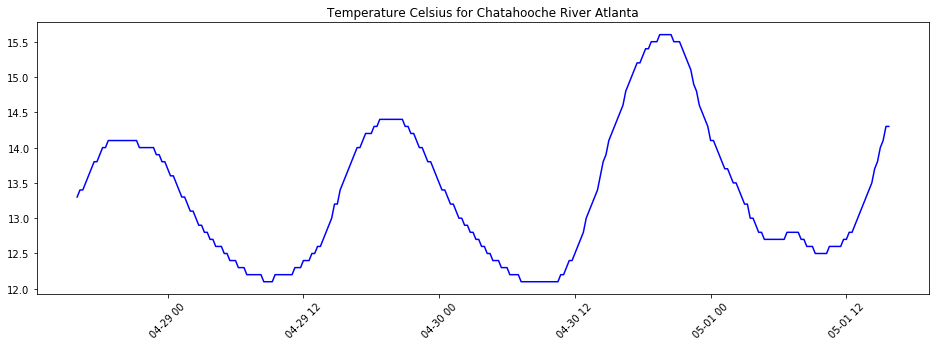

In [10]:
stream_plotter(usgs, '00010', site, 'blue');
# all the codes 00010, 00060, 00065, 00095, 63680


### Building Out  Bokeh Graphing Functions
 - First Function Foundation parts
     - Create a `ColumnDataSource` in bokeh 
     - Create a schema for our hover tool
     - create `source` and `hover` enities
 - Second Function The Time Series Graph!
 
 ### The `Sourcer` Function

In [11]:
def sourcer(data):
    source = ColumnDataSource(data={
        'date'      : data.index,
        '00060' : data['00060'],
        '00065'    : data['00065'],
        '00010'  : data['00010'],
        '63680': data['63680'],
        '00095': data['00095'],
        'time':data.index.time
    })
    
    hov= HoverTool(
    tooltips=[('Time', '@time{%H:%M}'),
              ( 'Discharge (cubic feet/second)','@00060' ),
             ('Gage Height (feet) ', '@00065'),
             ('Water Temperature (Celsius)', '@00010'),
             ('Condcutivity', '@00095'),
             ('Turbidity', '@63680')],
        formatters={
        'time'      : 'datetime', 
        'discharge' : 'printf', 
        'gage' : 'printf',
        'temp_c' : 'printf'
    },
    mode = 'vline'
    )
    return(source, hov)
source, hov = sourcer(usgs)

In [ ]:
#source.

### The `date_plot` Function

In [12]:
def date_plot(data, sensor, site = site, sensor_dict=sensor_dict, location_dict=location_dict):
    source, hov = sourcer(usgs)
    p = figure(plot_width=900, plot_height=400, title="{} at \t Site number: {} \t Location: {}".format(site, location_dict[site], sensor_dict[sensor]), x_axis_type="datetime")
    p.line(x='date', y = sensor, color='darkorchid', legend= sensor_dict[sensor].split()[0], source = source)
    p.xaxis.axis_label = 'Date'
    p.yaxis.axis_label = sensor_dict[sensor]
    p.xaxis.major_label_orientation = math.pi/4
    p.add_tools(hov)
    show(p)
 

In [13]:
   
date_plot(usgs, sensor = '00065')

In [ ]:
date_plot(usgs, sensor = '00095')

In [ ]:
date_plot(usgs,sensor = '00095')

In [ ]:
date_plot(usgs,sensor = '00060')

In [14]:
output_notebook()
date_plot(usgs, sensor = '00065')

Loading BokehJS ...

In [16]:
reset_output()
date_plot(usgs,sensor = '00010')  

In [ ]:
date_plot(usgs, sensor = '63680')

## Modifying Function for Flask
We need to push a two part plot to flask in the form of `div` and `script` this is accomplished using `components( )` to separate out the parts

In [17]:
def date_plot(data, sensor, site = site, sensor_dict=sensor_dict, location_dict=location_dict):
    source, hov = sourcer(usgs)
    p = figure(plot_width=900, plot_height=400, title="{} at \t Site number: {} \t Location: {}".format(site, location_dict[site], sensor_dict[sensor]), x_axis_type="datetime")
    p.line(x='date', y = sensor, color='#eb1736', legend= sensor_dict[sensor].split()[0], source = source)
    p.xaxis.axis_label = 'Date'
    p.yaxis.axis_label = sensor_dict[sensor]
    p.xaxis.major_label_orientation = math.pi/4
    p.add_tools(hov)
    #show(p)
    return(components(p))

In [18]:
script, div = date_plot(usgs, sensor = '63680')

### What We are Passing to Flask

In [19]:
script

'\n<script type="text/javascript">\n  (function() {\n    var fn = function() {\n      Bokeh.safely(function() {\n        (function(root) {\n          function embed_document(root) {\n            \n          var docs_json = \'{"c252c539-5443-41b7-a4d5-bbcd3d2044a9":{"roots":{"references":[{"attributes":{"mantissas":[1,2,5],"max_interval":500.0,"num_minor_ticks":0},"id":"1960","type":"AdaptiveTicker"},{"attributes":{},"id":"1958","type":"DatetimeTickFormatter"},{"attributes":{"text":"02336000 at \\\\t Site number: Chatahooche River Atlanta \\\\t Location: Turbidity"},"id":"1917","type":"Title"},{"attributes":{"base":60,"mantissas":[1,2,5,10,15,20,30],"max_interval":1800000.0,"min_interval":1000.0,"num_minor_ticks":0},"id":"1961","type":"AdaptiveTicker"},{"attributes":{},"id":"1993","type":"Selection"},{"attributes":{"bottom_units":"screen","fill_alpha":{"value":0.5},"fill_color":{"value":"lightgrey"},"left_units":"screen","level":"overlay","line_alpha":{"value":1.0},"line_color":{"value"

In [20]:
div

'\n<div class="bk-root" id="03b6f5e1-2a9f-4d39-90e2-5776a52429f2" data-root-id="1916"></div>'